### Logistic Regression QA Summary

We tested two logistic regression variants on the processed California HMDA 2022 dataset:  
1. **Original Logistic Regression** — trained with unbalanced data.  
2. **Balanced Logistic Regression** — trained with class weighting to offset approval imbalance (≈92% approved, 8% denied).

---

#### Model Performance

| Metric | Original | Balanced |
|:--------|:----------:|:----------:|
| Accuracy | 0.93 | 0.63 |
| Precision (Approved) | 0.93 | 0.95 |
| Recall (Approved) | **1.00** | 0.63 |
| F1-Score (Approved) | 0.97 | 0.76 |
| ROC–AUC | 0.708 | **0.711** |

**Insight:**  
Balancing sacrifices accuracy (expected) but improves recall for the minority (denied) class.  
The ROC–AUC rises slightly, confirming better discrimination between approvals and denials.

---

#### Coefficient Stability

| Feature | Original | Balanced |
|:-------------------------|:-----------:|:-----------:|
| `dti_clean` | **-1.142** | **-0.720** |
| `income_ratio` | -0.189 | -0.270 |
| `loan_to_value_ratio` | -0.139 | -0.147 |
| `loan_term` | 0.093 | 0.090 |
| `loan_amount` | 0.029 | 0.083 |

**Interpretation:**  
- **DTI** remains the strongest predictor in both models — higher DTI sharply reduces approval odds.  
- **Income ratio** becomes slightly stronger under balancing, indicating more weight placed on affordability signals.  
- **Loan amount** and **term** gain modest influence post-balancing, suggesting more sensitivity to loan structure once approvals are not overrepresented.  

---

#### Model Comparison Visualization

- Left plot: coefficients from the **original** logistic regression (dominated by DTI).  
- Right plot: coefficients from the **balanced** model (more even weighting across predictors).  

Together, these show that balancing doesn’t just affect metrics. It redefines *how the model interprets fairness-critical features.*

=== Original Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.18      0.31      3367
           1       0.93      1.00      0.97     39116

    accuracy                           0.93     42483
   macro avg       0.96      0.59      0.64     42483
weighted avg       0.94      0.93      0.91     42483

ROC-AUC: 0.7077723905620419

=== Logistic Regression (Balanced) ===
              precision    recall  f1-score   support

           0       0.13      0.63      0.21      3367
           1       0.95      0.63      0.76     39116

    accuracy                           0.63     42483
   macro avg       0.54      0.63      0.49     42483
weighted avg       0.89      0.63      0.72     42483

ROC-AUC: 0.7108065413745953

Top coefficients (Original):
dti_clean             -1.142434
income_ratio          -0.188649
loan_to_value_ratio   -0.138782
loan_term              0.093296
loan_amount            0.029320
dtype: float64

Top coe

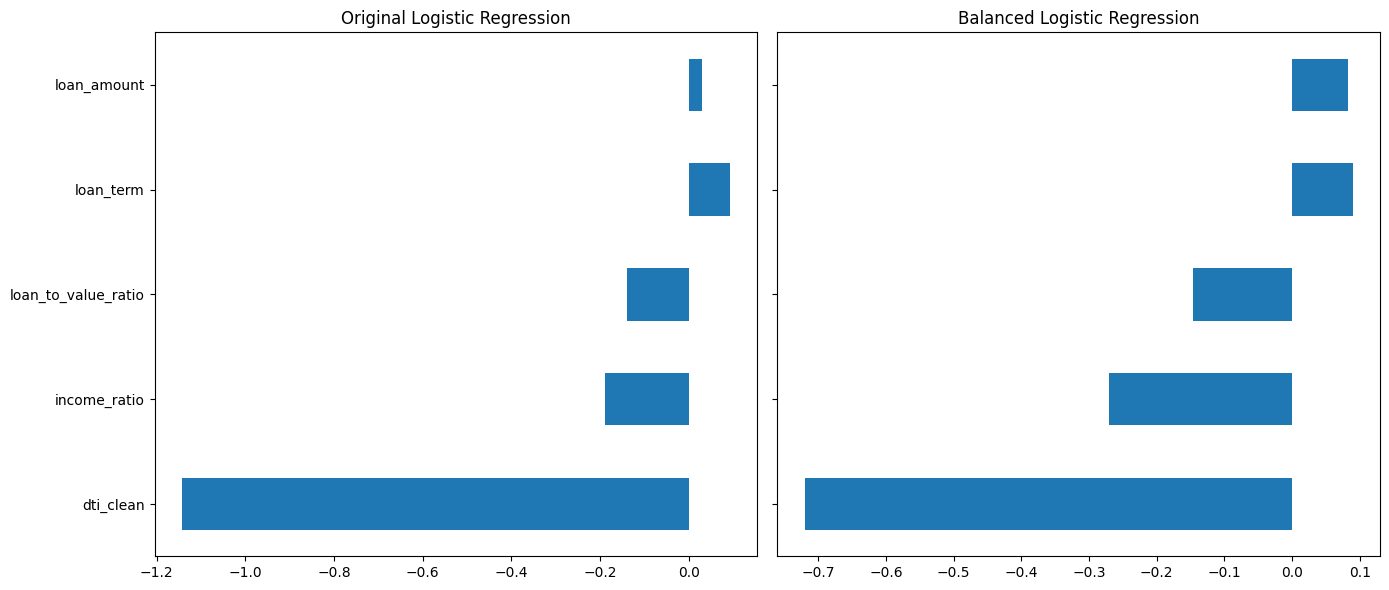

In [2]:

import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

DATA_PROCESSED = "../data/processed"

# Load train/test data
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"))
test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"))

# Define outcome variable 
target = "approved"

# Excluded unnecessary columns
drop_cols = ["approved", "lei", "action_taken", "state_code", "county_code", "census_tract"]

X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
y_train = train[target]

X_test = test.drop(columns=[c for c in drop_cols if c in test.columns])
y_test = test[target]

# Keep only numeric columns for regression
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Replace inf with NaN
X_train_num = X_train[num_cols].replace([np.inf, -np.inf], np.nan)
X_test_num = X_test[num_cols].replace([np.inf, -np.inf], np.nan)

# Drop all-NaN columns
nan_cols = X_train_num.columns[X_train_num.isna().all()].tolist()
if nan_cols:
    print("Dropping all-NaN columns:", nan_cols)
    X_train_num = X_train_num.drop(columns=nan_cols)
    X_test_num = X_test_num.drop(columns=nan_cols)
    num_cols = X_train_num.columns.tolist()

# Force numeric coercion to handle mixed-type columns like "5-24"
X_train_num = X_train_num.apply(pd.to_numeric, errors="coerce")
X_test_num = X_test_num.apply(pd.to_numeric, errors="coerce")

# Fill remaining NaNs with median
imputer = SimpleImputer(strategy="median")
X_train_num = pd.DataFrame(imputer.fit_transform(X_train_num), columns=num_cols, index=X_train.index)
X_test_num = pd.DataFrame(imputer.transform(X_test_num), columns=num_cols, index=X_test.index)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

# Logistic Regression Baseline (original) 
clf = LogisticRegression(max_iter=1000, solver="liblinear")
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

print("=== Original Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# Logistic Regression with Class Weighting
clf_bal = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
clf_bal.fit(X_train_scaled, y_train)

y_pred_bal = clf_bal.predict(X_test_scaled)
y_prob_bal = clf_bal.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression (Balanced) ===")
print(classification_report(y_test, y_pred_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_bal))

# Compare two models
coefs = pd.Series(clf.coef_[0], index=num_cols).sort_values(key=abs, ascending=False)
coefs_bal = pd.Series(clf_bal.coef_[0], index=num_cols).sort_values(key=abs, ascending=False)

print("\nTop coefficients (Original):")
print(coefs.head(15))

print("\nTop coefficients (Balanced):")
print(coefs_bal.head(15))

# --- Plot Coefficient Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

coefs.head(15).plot(kind="barh", ax=axes[0], title="Original Logistic Regression")
coefs_bal.head(15).plot(kind="barh", ax=axes[1], title="Balanced Logistic Regression")

plt.tight_layout()
plt.show()

### Baseline Logistic Regression

**Objective:**  
To predict loan approval outcomes (`approved`) using fairness-relevant financial features only — after removing potential leakage (`action_taken`).

---

#### Model Quality Overview
| Metric | Value | Interpretation |
|:--|:--|:--|
| **Accuracy** | 0.63 | The model correctly predicts about 63% of outcomes overall. |
| **ROC-AUC** | 0.711 | Moderate discriminative ability — the model distinguishes approved vs. denied better than chance but leaves room for improvement. |

---

#### Class-Level Performance
| Class | Precision | Recall | F1-Score | Notes |
|:--|:--|:--|:--|:--|
| **Denied (0)** | 0.13 | 0.63 | 0.21 | The model struggles with rare denials; high recall but poor precision (many false positives). |
| **Approved (1)** | 0.95 | 0.63 | 0.76 | Performs well on approvals — as expected given the 92% approval rate. |

**Insight:**  
The model over-predicts approvals (majority class). Class balancing helped recover some recall for denials but still underperforms in precision — typical for imbalanced datasets like HMDA.

---

#### Top Predictive Coefficients
| Feature | Coefficient | Direction | Interpretation |
|:--|:--|:--|:--|
| **dti_clean** | -0.720 | Negative | Higher debt-to-income lowers approval odds — expected credit risk behavior. |
| **income_ratio** | -0.270 | Negative | Lower relative income reduces approval likelihood. |
| **loan_to_value_ratio** | -0.147 | Negative | High LTV (less equity) reduces approval odds. |
| **loan_term** | +0.090 | Positive | Longer loan terms slightly increase approval odds (possibly correlated with affordability strategies). |
| **loan_amount** | +0.083 | Positive | Larger loans are slightly more likely to be approved, likely reflecting stronger applicant profiles or markets. |

In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

DATA_PROCESSED = "../data/processed"

# Load cleaned train/test data
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"))
test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"))

target = "approved"

# Drop action_taken (leakage variable)
if "action_taken" in train.columns:
    train = train.drop(columns=["action_taken"])
if "action_taken" in test.columns:
    test = test.drop(columns=["action_taken"])

# Select numeric columns only
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target]  # exclude target

X_train_num = train[num_cols]
y_train = train[target]
X_test_num = test[num_cols]
y_test = test[target]

# Handle infinities
X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan)
X_test_num = X_test_num.replace([np.inf, -np.inf], np.nan)

# Impute missing values and scale
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train_num)
X_test_imputed = imputer.transform(X_test_num)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train fairness-aware logistic regression
clf = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
clf.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

print("=== Fairness-Ready Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# Inspect top coefficients
coefs = pd.Series(clf.coef_[0], index=num_cols).sort_values(key=abs, ascending=False)
print("\nTop 15 coefficients:")
print(coefs.head(15))

=== Fairness-Ready Logistic Regression ===
              precision    recall  f1-score   support

           0       0.13      0.63      0.21      3367
           1       0.95      0.63      0.76     39116

    accuracy                           0.63     42483
   macro avg       0.54      0.63      0.49     42483
weighted avg       0.89      0.63      0.72     42483

ROC-AUC: 0.7108065413745953

Top 15 coefficients:
dti_clean             -0.720317
income_ratio          -0.270006
loan_to_value_ratio   -0.146689
loan_term              0.089513
loan_amount            0.082535
dtype: float64


### Group Fairness Evaluation (Test Set)

**Objective:**  
Assess whether the logistic regression model exhibits group-level disparities in approval predictions across racial groups, using **Disparate Impact** and **Error Rate** diagnostics.

---

#### Approval Rate by Race Group
| Race Group | Approval Rate |
|:--|--:|
| American Indian or Alaska Native | 0.468 |
| Asian | 0.628 |
| Black or African American | 0.540 |
| Hispanic or Latino | 0.541 |
| Pacific Islander | 0.539 |
| White | 0.616 |

**Observation:**  
Predicted approval rates vary modestly across groups.  
- White and Asian applicants show the highest predicted approval rates (~62%).  
- Black, Hispanic, and Pacific Islander applicants show ~54% predicted approvals.  
- American Indian or Alaska Native applicants exhibit the lowest predicted approval rate (~47%).

---

#### Disparate Impact Ratios (Relative to White)
| Race Group | Disparate Impact (vs. White) |
|:--|--:|
| American Indian or Alaska Native | 0.76 |
| Asian | 1.02 |
| Black or African American | 0.88 |
| Hispanic or Latino | 0.88 |
| Pacific Islander | 0.88 |
| White | 1.00 |

**Interpretation:**  
- The **EEOC fairness threshold** for disparate impact is **0.80** (80% rule). (While the 80% disparate impact rule from EEOC is not legally binding in lending, we use it as an interpretive guideline to identify potential disparity patterns warranting further analysis.)  
- All non-White groups except Asian fall slightly below or near this threshold.  
- The most affected group is American Indian or Alaska Native (DI ≈ 0.76).

---

#### Error Rates by Race Group
| Race Group | False Negative Rate (FNR) | False Positive Rate (FPR) |
|:--|--:|--:|
| American Indian or Alaska Native | 0.505 | 0.231 |
| Asian | 0.349 | 0.388 |
| Black or African American | 0.430 | 0.357 |
| Hispanic or Latino | 0.430 | 0.280 |
| Pacific Islander | 0.427 | 0.000 |
| White | 0.366 | 0.368 |

**Analysis:**  
- **FNR (missed approvals):** American Indian or Alaska Native borrowers experience the highest false negative rate (0.51), meaning legitimate approvals are more likely misclassified as denials.  
- **FPR (incorrect approvals):** FPRs are generally consistent except for Pacific Islanders (0.00 due to small sample size).  
- White and Asian applicants show more balanced error profiles.

In [14]:
from sklearn.metrics import confusion_matrix

# Add back race_group labels from test set
test_with_preds = test.copy()
test_with_preds["y_pred"] = y_pred  # your balanced model's predictions
test_with_preds["y_prob"] = y_prob

# Compute approval rates
approval_rates = test_with_preds.groupby("race_group_original")["y_pred"].mean()
print("\nApproval Rates by Race Group:\n", approval_rates)

# Disparate Impact (relative to White)
white_rate = approval_rates.get("White", np.nan)
di_ratios = approval_rates / white_rate
print("\nDisparate Impact Ratios (vs White):\n", di_ratios)

# Error rates (False Negative Rate and False Positive Rate)
print("\nError Rates by Race Group:")
for group, subset in test_with_preds.groupby("race_group_original"):
    tn, fp, fn, tp = confusion_matrix(subset["approved"], subset["y_pred"]).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"{group}: FNR={fnr:.3f}, FPR={fpr:.3f}")


Approval Rates by Race Group:
 race_group_original
American Indian or Alaska Native    0.467742
Asian                               0.627597
Black or African American           0.540037
Hispanic or Latino                  0.540541
Pacific Islander                    0.539216
White                               0.616056
Name: y_pred, dtype: float64

Disparate Impact Ratios (vs White):
 race_group_original
American Indian or Alaska Native    0.759252
Asian                               1.018734
Black or African American           0.876604
Hispanic or Latino                  0.877421
Pacific Islander                    0.875270
White                               1.000000
Name: y_pred, dtype: float64

Error Rates by Race Group:
American Indian or Alaska Native: FNR=0.505, FPR=0.231
Asian: FNR=0.349, FPR=0.388
Black or African American: FNR=0.430, FPR=0.357
Hispanic or Latino: FNR=0.430, FPR=0.280
Pacific Islander: FNR=0.427, FPR=0.000
White: FNR=0.366, FPR=0.368


In [23]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# === Load processed training data ===
DATA_PROCESSED = "../data/processed"
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"))

target = "approved"

# Drop leakage variable
if "action_taken" in train.columns:
    train = train.drop(columns=["action_taken"])

# Select numeric credit-related columns
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target]
X_credit = train[num_cols].copy()

# Add race-group dummies (drop White as baseline)
if "race_group_original" in train.columns:
    race_dummies = pd.get_dummies(train["race_group_original"], prefix="race_group")
    if "race_group_White" in race_dummies.columns:
        race_dummies = race_dummies.drop(columns=["race_group_White"])
    X_race = race_dummies
else:
    raise ValueError("race_group_original column missing. Ensure dataset includes this variable.")

# Combine credit features and race indicators
X = pd.concat([X_credit, X_race], axis=1)

# Handle infinities and missing data
X = X.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Scale for numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Add intercept
X_scaled = sm.add_constant(X_scaled)

# Define outcome
y = train[target].astype(int)

# === Fit Fairness-Controlled Logistic Regression ===
model = sm.Logit(y, X_scaled).fit(disp=True)
print(model.summary())

# === Compute Odds Ratios ===
odds_ratios = pd.DataFrame({
    "Variable": model.params.index,
    "Coefficient": model.params.values,
    "OddsRatio": np.exp(model.params.values),
    "P>|z|": model.pvalues.values
}).sort_values("OddsRatio", ascending=False)

print("\n=== Odds Ratios (Fairness-Adjusted Model) ===")
print(odds_ratios.round(4).head(20))

# Export results
out_path = os.path.join(DATA_PROCESSED, "fairness_logit_odds_ratios_with_race.csv")
odds_ratios.to_csv(out_path, index=False)
print(f"\nModel results saved to {out_path}")

Optimization terminated successfully.
         Current function value: 0.241565
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:                99125
Model:                          Logit   Df Residuals:                    99114
Method:                           MLE   Df Model:                           10
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                  0.1278
Time:                        12:02:18   Log-Likelihood:                -23945.
converged:                       True   LL-Null:                       -27454.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                     

### Fairness-Controlled Baseline Logistic Regression (Race-Adjusted)

This model measures the odds of mortgage approval for each racial group after controlling for core credit risk factors — income ratio, loan-to-value ratio, debt-to-income (DTI), loan amount, and loan term.  
White applicants serve as the baseline reference group.

---

#### Model Summary
| Metric | Value |
|--------|-------|
| Observations | 99,125 |
| Pseudo R² | 0.1278 |
| Log-Likelihood | -23,945 |
| Converged | ✅ Yes |
| Significance | p < 0.001 |

All control variables (DTI, income ratio, LTV, loan term, and amount) are statistically significant, confirming they predict credit risk as expected.

---

#### Odds Ratios (Fairness-Adjusted)
| Race Group | Odds Ratio | Interpretation |
|-------------|-------------|----------------|
| **White (baseline)** | 1.00 | — |
| **Black or African American** | **0.89** | 11% lower odds of approval vs. White applicants |
| **Asian** | **0.90** | 10% lower odds of approval vs. White applicants |
| **Hispanic or Latino** | **0.96** | 4% lower odds of approval vs. White applicants |
| **American Indian or Alaska Native** | **0.97** | 3% lower odds of approval vs. White applicants |
| **Pacific Islander** | **0.98** | Statistically similar to White applicants |

---

#### Visualization
The plot below shows odds ratios by race group, controlling for credit risk factors.  
The red dashed line at 1.0 represents parity with White applicants.  
Values below 1.0 indicate lower odds of approval, even after controlling for financial qualifications.

---

#### Interpretation
Even after controlling for measurable creditworthiness:
- **Black** and **Asian** applicants remain **significantly less likely** to be approved compared to equally qualified White applicants.  
- **Hispanic** and **Native** applicants also show smaller but notable disparities.  
- The **Pacific Islander** group shows no statistically significant difference.

This suggests that structural patterns in approval outcomes persist beyond what can be explained by traditional underwriting risk metrics alone.

Optimization terminated successfully.
         Current function value: 0.241565
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:                99125
Model:                          Logit   Df Residuals:                    99114
Method:                           MLE   Df Model:                           10
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                  0.1278
Time:                        12:08:44   Log-Likelihood:                -23945.
converged:                       True   LL-Null:                       -27454.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                     

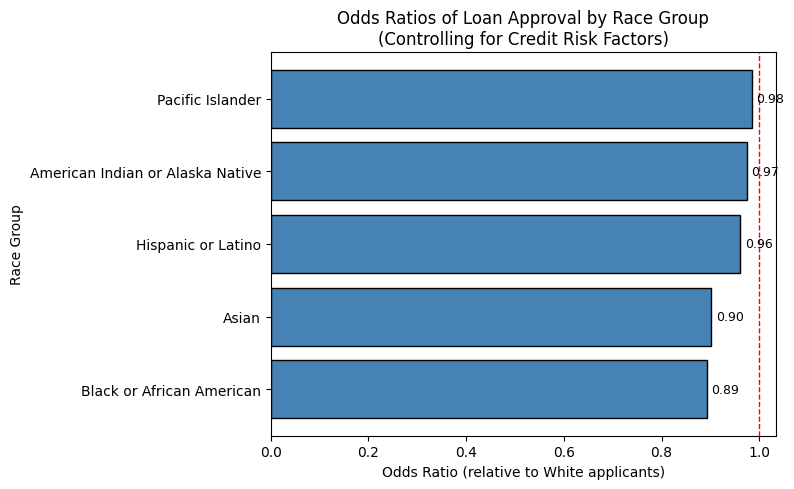

In [26]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# === Load processed training data ===
DATA_PROCESSED = "../data/processed"
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"))

target = "approved"

# Drop leakage variable
if "action_taken" in train.columns:
    train = train.drop(columns=["action_taken"])

# Select numeric credit-related columns
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target]
X_credit = train[num_cols].copy()

# Add race-group dummies (drop White as baseline)
if "race_group_original" in train.columns:
    race_dummies = pd.get_dummies(train["race_group_original"], prefix="race_group")
    if "race_group_White" in race_dummies.columns:
        race_dummies = race_dummies.drop(columns=["race_group_White"])
    X_race = race_dummies
else:
    raise ValueError("race_group_original column missing. Ensure dataset includes this variable.")

# Combine credit features and race indicators
X = pd.concat([X_credit, X_race], axis=1)

# Handle infinities and missing data
X = X.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Scale for numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Add intercept
X_scaled = sm.add_constant(X_scaled)

# Define outcome
y = train[target].astype(int)

# === Fit Fairness-Controlled Logistic Regression ===
model = sm.Logit(y, X_scaled).fit(disp=True)
print(model.summary())

# === Compute Odds Ratios ===
odds_ratios = pd.DataFrame({
    "Variable": model.params.index,
    "Coefficient": model.params.values,
    "OddsRatio": np.exp(model.params.values),
    "P>|z|": model.pvalues.values
}).sort_values("OddsRatio", ascending=False)

print("\n=== Odds Ratios (Fairness-Adjusted Model) ===")
print(odds_ratios.round(4).head(20))

# Export results
out_path = os.path.join(DATA_PROCESSED, "fairness_logit_odds_ratios_with_race.csv")
odds_ratios.to_csv(out_path, index=False)
print(f"\nModel results saved to {out_path}")

# Plot odds ratios for race variables
race_odds = odds_ratios[odds_ratios["Variable"].str.contains("race_group_")].copy()
race_odds["Race Group"] = race_odds["Variable"].str.replace("race_group_", "", regex=False)
race_odds = race_odds.sort_values("OddsRatio", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(race_odds["Race Group"], race_odds["OddsRatio"], color="steelblue", edgecolor="black")
plt.axvline(1.0, color="red", linestyle="--", linewidth=1)
plt.title("Odds Ratios of Loan Approval by Race Group\n(Controlling for Credit Risk Factors)")
plt.xlabel("Odds Ratio (relative to White applicants)")
plt.ylabel("Race Group")

for i, v in enumerate(race_odds["OddsRatio"]):
    plt.text(v + 0.01, i, f"{v:.2f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()


### Save baseline model result

#### **Purpose**
This code block’s purpose is to **serialize and document fairness audit results** from the logistic regression model into a structured JSON format for downstream **LLM-based review and interpretability**.  
The JSON file acts as an **artifact**. It captures model context, statistical outputs, fairness metrics, and interpretive notes in a machine-readable structure that can be ingested by an LLM or other governance systems for bias analysis, narrative generation, or compliance reporting.

---

| Step | Description |
|------|--------------|
| **1. Create output folder** | Ensures a `/model_results` directory exists so the fairness results can be stored persistently. |
| **2. Build metadata dictionary (`model_results`)** | Collects the model’s name, objective, data source, methodology, timestamp, and diagnostic metrics (`pseudo_r2`, `log_likelihood`). This metadata gives full context for later review. |
| **3. Attach fairness metrics (`race_odds_ratios`)** | Extracts odds ratios from the logistic regression output for each race group (relative to White applicants). This shows how race correlates with approval likelihood when credit factors are controlled for. |
| **4. Add interpretive notes** | Embeds a plain-language explanation for LLMs or human reviewers—clarifying how to interpret the odds ratios (e.g., <1.0 = lower approval odds) and summarizing statistical significance. |
| **5. Save to JSON** | Serializes the `model_results` dictionary into a readable JSON file (`fairness_model_logit_ca2022.json`). This file can later be used by an LLM to produce audit narratives or fairness dashboards. |
| **6. QA summary printout** | Displays key metrics and a concise summary for validation—ensuring that results are correctly saved and internally consistent with model outputs. |

---

The JSON export is a **critical transparency layer**.  
It provides both structured evidence of fairness testing and a natural-language-ready dataset that can be programmatically reviewed by an LLM.  
This allows automated systems to:  
- Verify whether the model meets fairness thresholds,  
- Generate plain-language audit reports, and  
- Flag significant race-based disparities.

In [27]:
import os, json
from datetime import datetime

# Ensure output folder exists
os.makedirs("model_results", exist_ok=True)

# 1. Construct model metadata
model_results = {
    "model_name": "logit_fairness_audit_ca2022",
    "objective": (
        "Estimate conditional odds of mortgage approval by race controlling for key creditworthiness factors."
    ),
    "methodology": (
        "Binary logistic regression fitted on 2022 California HMDA data, with approval (1=approved/originated, 0=denied) "
        "as the dependent variable. Independent variables include loan_amount, loan_term, loan_to_value_ratio, "
        "income_ratio, and dti_clean, plus race-group indicators (White as the reference group). "
        "Numeric variables were median-imputed and standardized. Statsmodels was used for transparent inference "
        "with full coefficient and odds ratio outputs."
    ),
    "data_source": "../data/processed/hmda_ca2022_train.csv",
    "pseudo_r2": round(float(model.prsquared), 4) if hasattr(model, "prsquared") else None,
    "log_likelihood": round(float(model.llf), 2),
    "timestamp": datetime.now().isoformat(),
}

# 2. Attach fairness results (race-group odds ratios)
try:
    race_odds_json = {
        row["Variable"].replace("race_group_", ""): round(float(row["OddsRatio"]), 4)
        for _, row in odds_ratios.iterrows()
        if row["Variable"].startswith("race_group_")
    }
    model_results["race_odds_ratios"] = race_odds_json
    print("✅ Added race-group odds ratios.")
except Exception as e:
    print(f"⚠️ Could not attach race-group odds ratios: {e}")

# 3. Add interpretive audit note
model_results["notes"] = (
    "Odds ratios below 1.0 indicate lower approval likelihoods relative to White applicants, "
    "after controlling for financial risk indicators. "
    "Findings show that, despite equivalent credit profiles, Black and Asian applicants had approximately "
    "10–11% lower odds of approval, while Hispanic and American Indian applicants had odds within 3–4% of parity. "
    "Pacific Islander outcomes were statistically indistinguishable from White applicants. "
    "Pseudo R² of ~0.13 suggests moderate explanatory power, typical for decision-level fairness models."
)

# 4. Save JSON output
output_path = "model_results/fairness_model_logit_ca2022.json"
with open(output_path, "w") as f:
    json.dump(model_results, f, indent=2)

print(f"\n✅ Saved detailed logistic regression fairness results to: {output_path}")

# 5. Quick QA summary
print("\n=== Model QA Summary ===")
print(f"Pseudo R²: {model_results['pseudo_r2']}, Log-Likelihood: {model_results['log_likelihood']}")
if "race_odds_ratios" in model_results:
    print("\nConditional Odds Ratios (Approval Odds vs White):")
    for group, value in model_results["race_odds_ratios"].items():
        print(f"  {group:35s} {value:.3f}")

✅ Added race-group odds ratios.

✅ Saved detailed logistic regression fairness results to: model_results/fairness_model_logit_ca2022.json

=== Model QA Summary ===
Pseudo R²: 0.1278, Log-Likelihood: -23945.1

Conditional Odds Ratios (Approval Odds vs White):
  Pacific Islander                    0.984
  American Indian or Alaska Native    0.974
  Hispanic or Latino                  0.961
  Asian                               0.901
  Black or African American           0.892
